In [ ]:
! pip install numpy
! pip install pandas
! pip install catboost
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn
! pip install mlxtend

In [1]:
from pandas import read_csv

general_data = read_csv('general_data.csv')
manager_survey_data = read_csv('manager_survey_data.csv')
employee_survey_data = read_csv('employee_survey_data.csv')

In [2]:
data = general_data.merge(manager_survey_data, on='EmployeeID', how='inner').merge(employee_survey_data,
                                                                                   on='EmployeeID', how='inner')

In [3]:
data.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,...,11.279936,2.799320,7.008163,2.187755,4.123129,2.729932,3.153741,2.723603,2.728246,2.761436
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,...,7.782222,1.288978,6.125135,3.221699,3.567327,0.711400,0.360742,1.092756,1.101253,0.706245
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,15.000000,3.000000,9.000000,3.000000,7.000000,3.000000,3.000000,4.000000,4.000000,3.000000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [4]:
in_times = read_csv('in_time.csv')
out_times = read_csv('out_time.csv')

In [5]:
from pandas import DataFrame, to_datetime


def preprocess_time_dataframe(times: DataFrame) -> DataFrame:
    """
    Preprocesses the dataframe: replaces NA with None and converts all dates to time in seconds format
    :param times: input dataframe with in/out times
    :return: preprocessed dataframe 
    """

    times[times == 'NA'] = None
    for column in times.columns[1:]:
        times[column] = to_datetime(times[column]).map(
            lambda x: x if x is None else (x - x.replace(hour=0, minute=0, second=0)).total_seconds())

    return times

In [6]:
relevant_time_columns = in_times.columns[1:]

In [7]:
in_times = preprocess_time_dataframe(in_times)[relevant_time_columns]
out_times = preprocess_time_dataframe(out_times)[relevant_time_columns]

In [8]:
working_time = out_times[relevant_time_columns] - in_times[relevant_time_columns]
working_time.index = in_times.index
mean_working_time = working_time.mean(axis=1)
mean_working_time.name = 'MeanWorkingTime'
assymetry_of_working_time = (working_time - mean_working_time.mean()).apply(lambda x: (x / 3600) ** 3).mean(axis=1)
assymetry_of_working_time.name = 'AsymmetryOfOverworking'

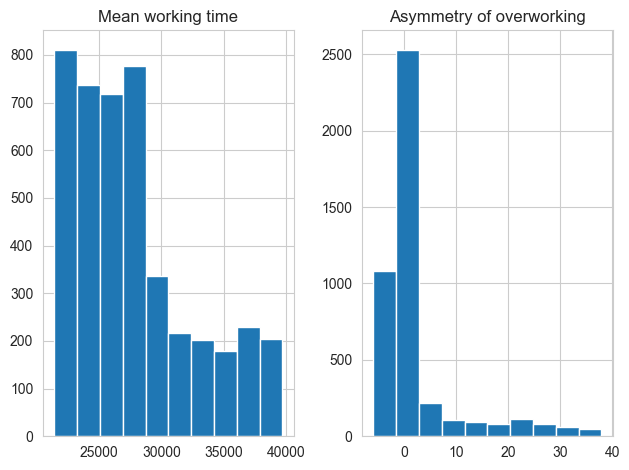

In [9]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2)
axes[0].hist(mean_working_time)
axes[0].set_title('Mean working time')
axes[1].hist(assymetry_of_working_time)
axes[1].set_title('Asymmetry of overworking')
plt.tight_layout()

In [10]:
data = data.merge(mean_working_time, left_on='EmployeeID', right_index=True).merge(assymetry_of_working_time,
                                                                                   left_on='EmployeeID',
                                                                                   right_index=True)

In [11]:
data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'MeanWorkingTime',
       'AsymmetryOfOverworking'],
      dtype='object')

In [12]:
said_no, said_yes = data['Attrition'].value_counts()
said_no, said_yes

(3698, 711)

In [13]:
# use weights for better visualizations because of class imbalance

yes_weight = said_no / said_yes
no_weight = 1
weights = [((yes_weight - no_weight) * (row['Attrition'] == 'Yes') + no_weight) for _, row in data.iterrows()]

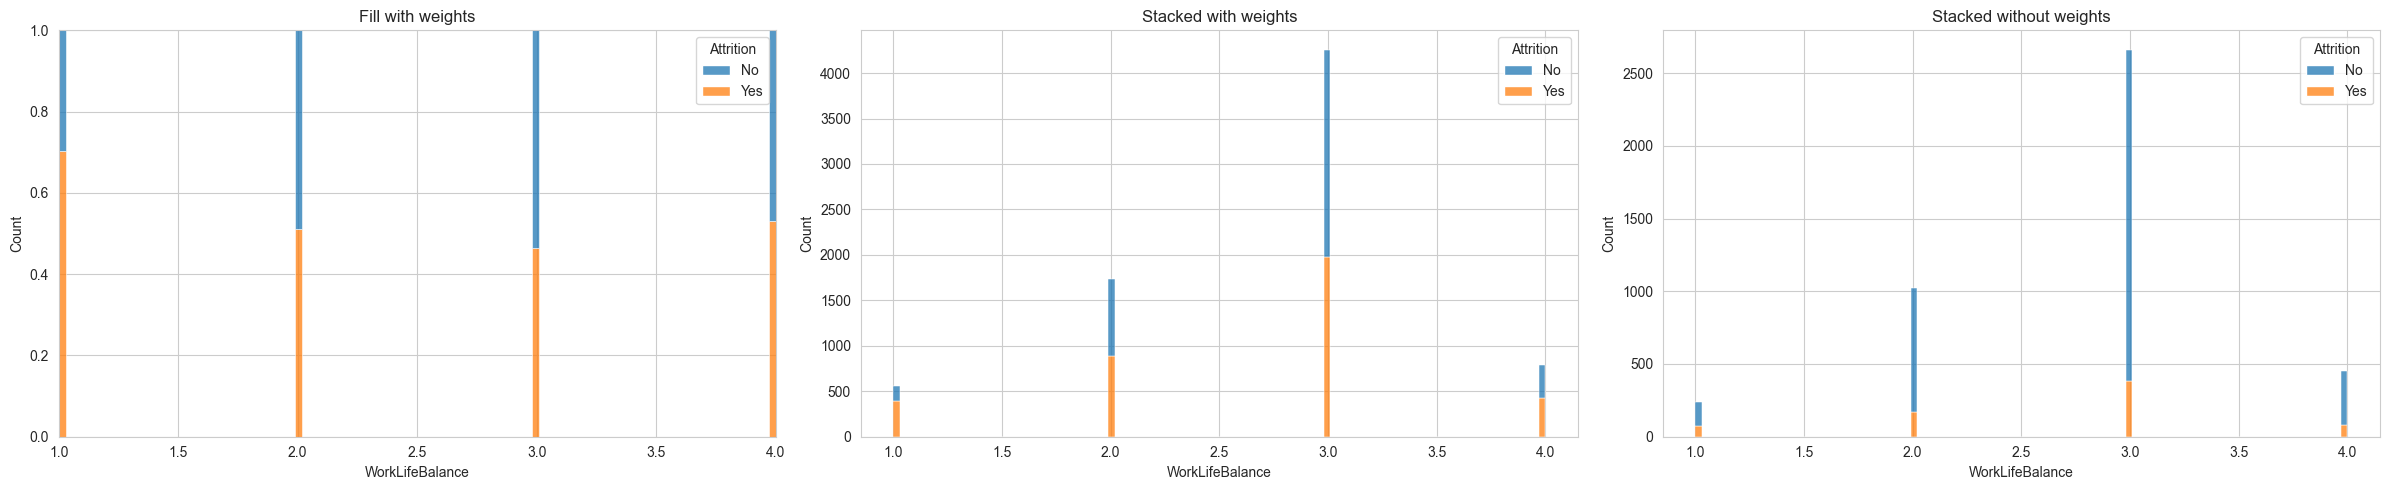

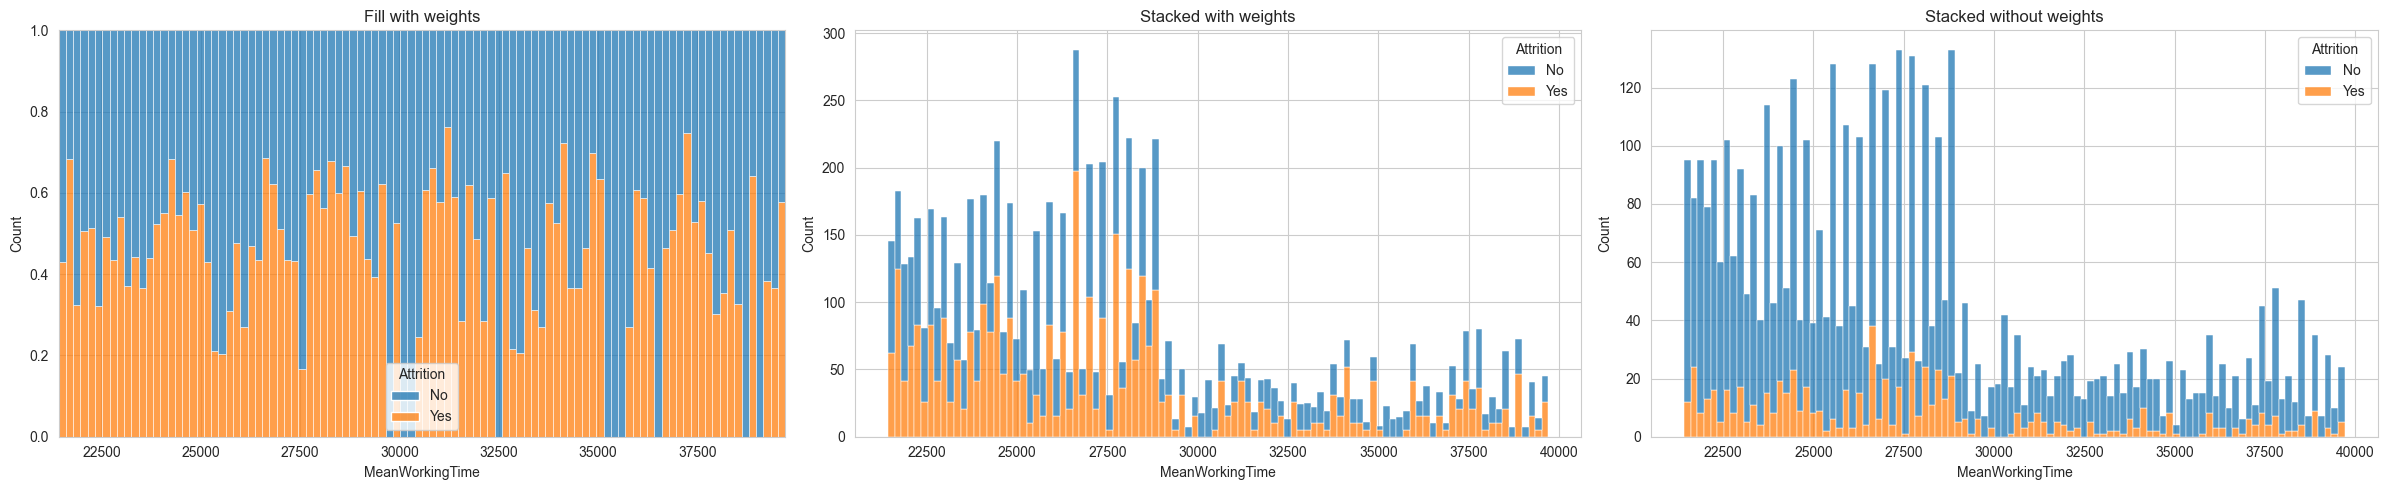

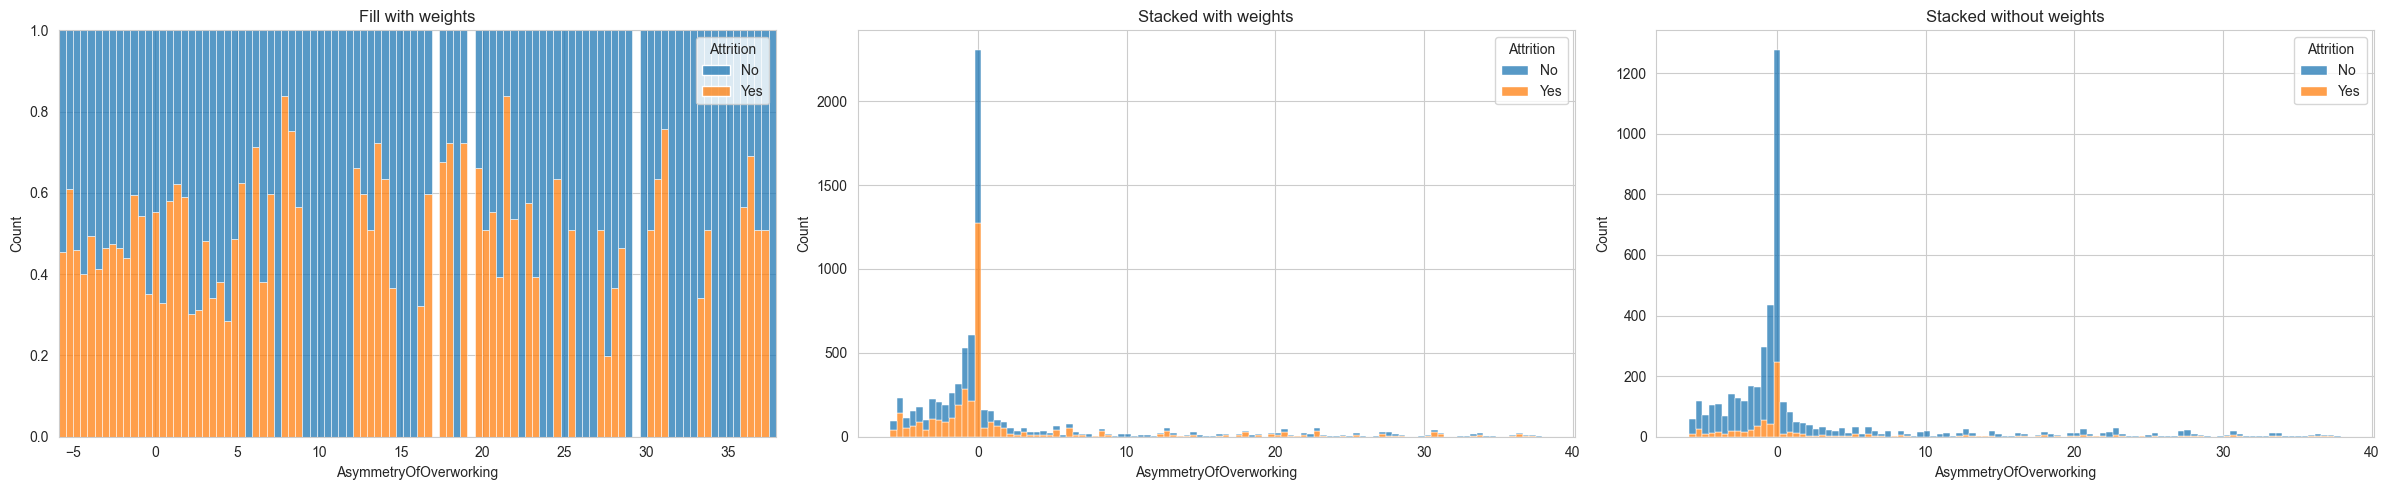

In [14]:
import seaborn as sns

log_scaled = {'Asymmetry of overworking'}

for i in range(len(data.columns)):
    _, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
    ax[0].set_title('Fill with weights')
    ax[1].set_title('Stacked with weights')
    ax[2].set_title('Stacked without weights')
    sns.histplot(data=data, hue='Attrition', x=data.columns[i], log_scale=data.columns[i] in log_scaled, multiple='fill', weights=weights, ax=ax[0], bins=100)
    sns.histplot(data=data, hue='Attrition', x=data.columns[i], log_scale=data.columns[i] in log_scaled, multiple='stack', weights=weights, ax=ax[1], bins=100)
    sns.histplot(data=data, hue='Attrition', x=data.columns[i], log_scale=data.columns[i] in log_scaled, multiple='stack', ax=ax[2], bins=100)
    if data[data.columns[i]].dtype == object: 
        for j in range(3):
            ax[j].xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

In [58]:
plot = sns.pairplot(data, hue='Attrition', height=5, corner=True, diag_kind='hist')

for ax in plot.axes.flat:
    ax.tick_params(axis='both', labelleft=True, labelbottom=True)
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig('pairplots.png')
plt.close()

print('Done')

Done


In [15]:
from pandas import get_dummies

categorical_columns = [column for column in data.columns if data[column].dtype == object]

preprocessed_cat_columns = get_dummies(data[categorical_columns])
preprocessed_data = data.drop(columns=categorical_columns).join(preprocessed_cat_columns).drop(columns=['Attrition_No']).rename(columns={'Attrition_Yes': 'Attrition'})

In [16]:
preprocessed_data

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,51,6,2,1,1,1,131160,1.0,11,8,...,False,False,False,False,False,False,False,True,False,True
1,31,10,1,1,2,1,41890,0.0,23,8,...,False,False,False,True,False,False,False,False,True,True
2,32,17,4,1,3,4,193280,1.0,15,8,...,False,False,False,False,True,False,False,True,False,True
3,38,2,5,1,4,3,83210,3.0,11,8,...,False,False,False,False,False,False,False,True,False,True
4,32,10,1,1,5,1,23420,4.0,12,8,...,False,False,False,False,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,29,4,3,1,4405,2,35390,1.0,18,8,...,False,False,False,False,False,False,False,False,True,True
4405,42,5,4,1,4406,1,60290,3.0,17,8,...,False,False,False,True,False,False,False,False,True,True
4406,29,2,4,1,4407,1,26790,2.0,15,8,...,False,False,False,False,False,False,True,False,False,True
4407,25,25,2,1,4408,2,37020,0.0,20,8,...,False,False,False,False,True,False,False,True,False,True


In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(preprocessed_data.drop(columns=['Attrition']), preprocessed_data['Attrition'], test_size=0.2, random_state=42)

In [19]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy_score(y_test, clf.predict(x_test)), roc_auc_score(y_test.to_numpy().reshape(-1), clf.predict_proba(x_test)[:, 1])

(0.9591836734693877, 0.9568971651030178)

In [22]:
from sklearn.tree import plot_tree

plt.figure(figsize=(150, 50))
plot_tree(clf, fontsize=8)
plt.savefig('tree.png', dpi=100)
plt.close()

In [23]:
list(sorted(zip(x_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True))

[('DistanceFromHome', nan),
 ('EmployeeID', nan),
 ('MonthlyIncome', 0.02545796518677591),
 ('Age', 0.021408820016966368),
 ('NumCompaniesWorked', 0.014806607124626876),
 ('TotalWorkingYears', nan),
 ('TrainingTimesLastYear', nan),
 ('EnvironmentSatisfaction', 0.016751882299243653),
 ('YearsAtCompany', 0.015465268784880514),
 ('WorkLifeBalance', 0.014126273994031673),
 ('JobLevel', 0.013248101303920557),
 ('JobSatisfaction', 0.012720086129440165),
 ('YearsSinceLastPromotion', 0.008511944075881763),
 ('PercentSalaryHike', 0.007799725891300423),
 ('Education', 0.005748629333822016),
 ('StockOptionLevel', 0.005535391078244005),
 ('MeanWorkingTime', nan),
 ('AsymmetryOfOverworking', nan),
 ('EducationField_Marketing', nan),
 ('MaritalStatus_Single', 0.007121360671777936),
 ('JobRole_Research Director', 0.004501720516639952),
 ('BusinessTravel_Travel_Frequently', 0.003624533642962902),
 ('Gender_Female', 0.0027849321672549095),
 ('BusinessTravel_Non-Travel', 0.0027757966150341656),
 ('Busin

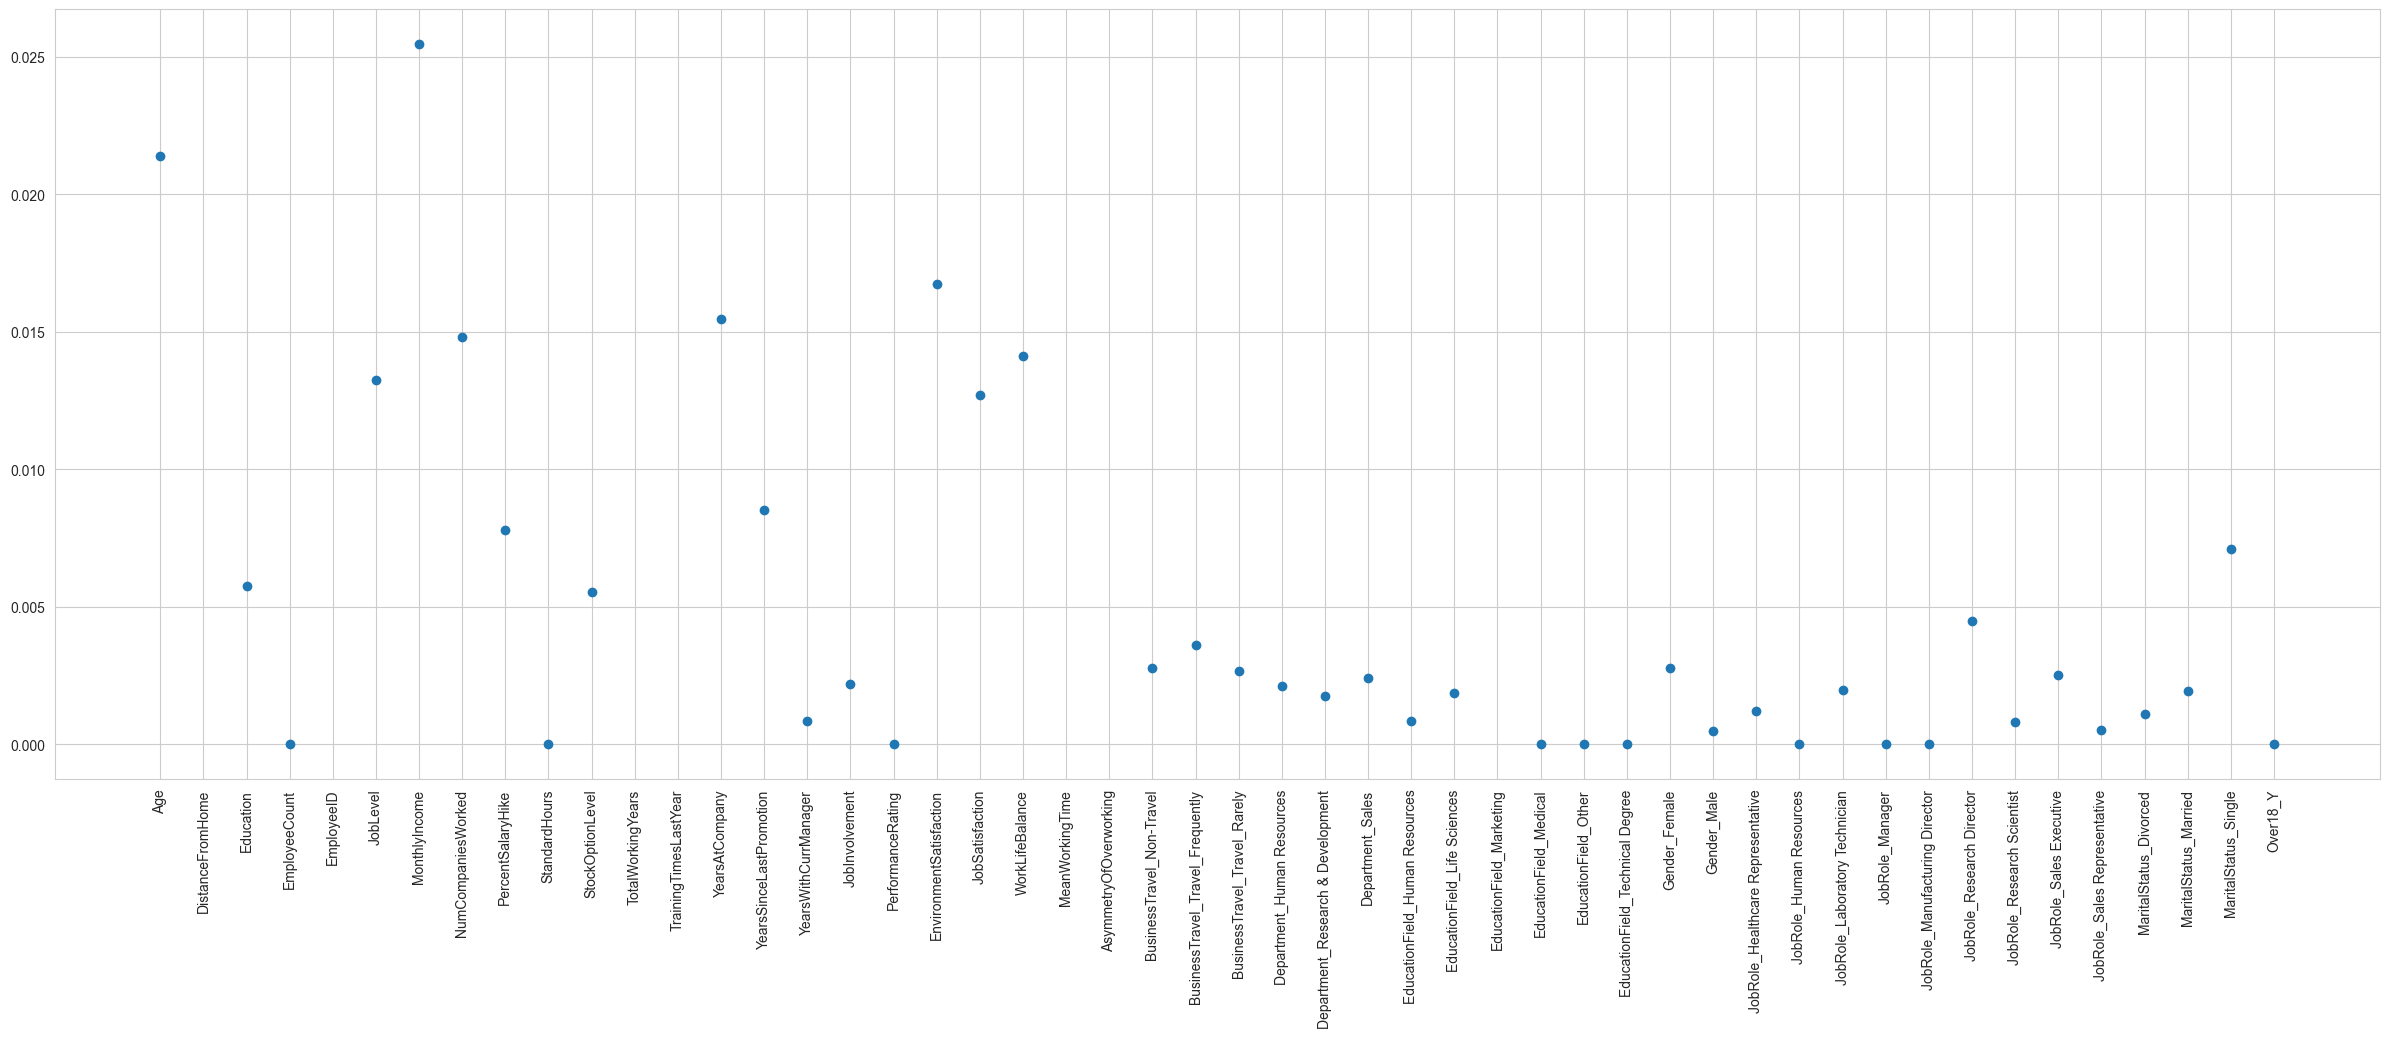

In [24]:
plt.figure(figsize=(30, 10))
plt.scatter(x=x_train.columns, y=clf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

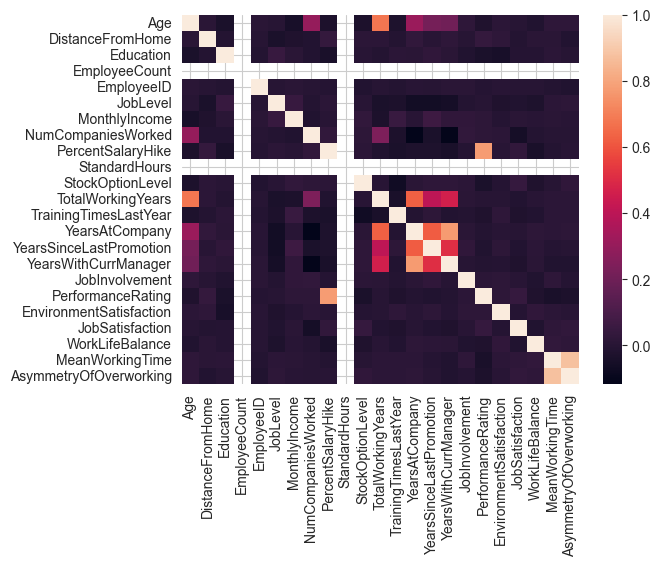

In [25]:
numeric_columns = list(filter(lambda x: x not in categorical_columns, data.columns))
sns.heatmap(data[numeric_columns].corr())
plt.show()